# 测试 APM 方法梯度流

验证使用 APM 方法计算全原子坐标时，梯度能否回传到 `xyz_bb`。


In [ ]:
import torch
import sys
import os



from BondFlow.models.allatom_wrapper import AllAtomWrapper

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


PyTorch version: 2.6.0+cu124
CUDA available: False


## 1. 创建测试数据


In [ ]:
# 设置随机种子
torch.manual_seed(42)

# 创建测试数据
B, L = 1, 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# xyz_bb 需要梯度
xyz_bb = torch.randn(B, L, 3, 3, device=device, requires_grad=True)
seq = torch.randint(0, 20, (B, L), device=device)
alphas_sincos = torch.randn(B, L, 10, 2, device=device)

print(f"输入形状:")
print(f"  xyz_bb: {xyz_bb.shape}, requires_grad={xyz_bb.requires_grad}")
print(f"  seq: {seq.shape}")
print(f"  alphas_sincos: {alphas_sincos.shape}")
print(f"  device: {device}")


输入形状:
  xyz_bb: torch.Size([1, 10, 3, 3]), requires_grad=True
  seq: torch.Size([1, 10])
  alphas_sincos: torch.Size([1, 10, 10, 2])
  device: cpu


## 2. 创建 AllAtomWrapper (APM backend)


In [ ]:
try:
    wrapper = AllAtomWrapper(backend='apm', device=device)
    print("✅ AllAtomWrapper (APM) 创建成功")
except Exception as e:
    print(f"❌ AllAtomWrapper (APM) 创建失败: {e}")
    print("   可能原因: APM 模块未安装或不可用")
    raise


✅ AllAtomWrapper (APM) 创建成功


## 3. 前向传播


In [ ]:
try:
    RTs, out14 = wrapper(seq, xyz_bb, alphas_sincos)
    print("✅ 前向传播成功")
    print(f"  输出形状: out14 = {out14.shape}")
    print(f"  out14.requires_grad = {out14.requires_grad}")
    print(f"  out14.dtype = {out14.dtype}")
    print(f"  out14 统计: min={out14.min().item():.4f}, max={out14.max().item():.4f}, mean={out14.mean().item():.4f}")
except Exception as e:
    print(f"❌ 前向传播失败: {e}")
    import traceback
    traceback.print_exc()
    raise


✅ 前向传播成功
  输出形状: out14 = torch.Size([1, 10, 14, 3])
  out14.requires_grad = True
  out14.dtype = torch.float32
  out14 统计: min=nan, max=nan, mean=nan


## 4. 检查计算图连接


In [ ]:
# 检查输出是否在计算图中
if not out14.requires_grad:
    print("⚠️  警告: out14.requires_grad = False")
    print("   输出不在计算图中，梯度无法回传")
else:
    print("✅ out14 在计算图中")
    
# 检查是否有 grad_fn
if out14.grad_fn is not None:
    print(f"✅ out14 有 grad_fn: {type(out14.grad_fn).__name__}")
    print(f"   计算图节点: {out14.grad_fn}")
else:
    print("⚠️  警告: out14.grad_fn = None")
    print("   可能不在计算图中")


✅ out14 在计算图中
✅ out14 有 grad_fn: WhereBackward0
   计算图节点: <WhereBackward0 object at 0x7fe545b0c340>


## 5. 反向传播测试


In [ ]:
# 清零梯度
if xyz_bb.grad is not None:
    xyz_bb.grad.zero_()

# 计算损失并反向传播
try:
    # 使用一个简单的损失函数（只对有效原子计算）
    valid_mask = ~torch.isnan(out14)
    loss = out14[valid_mask].sum()
    print(f"损失值: {loss.item():.6f}")
    print(f"有效原子数: {valid_mask.sum().item()}/{valid_mask.numel()}")
    
    # 反向传播
    loss.backward()
    print("✅ 反向传播成功")
except Exception as e:
    print(f"❌ 反向传播失败: {e}")
    import traceback
    traceback.print_exc()
    raise


损失值: 1.241589
有效原子数: 246/420
✅ 反向传播成功


## 6. 检查梯度


✅ 梯度能够回传到 xyz_bb!
  梯度形状: torch.Size([1, 10, 3, 3])
  梯度范数: 64.086777
  梯度最大值: 23.457497
  梯度最小值: 0.077797
  梯度平均值: 4.830070

✅ 梯度正常，可以用于训练


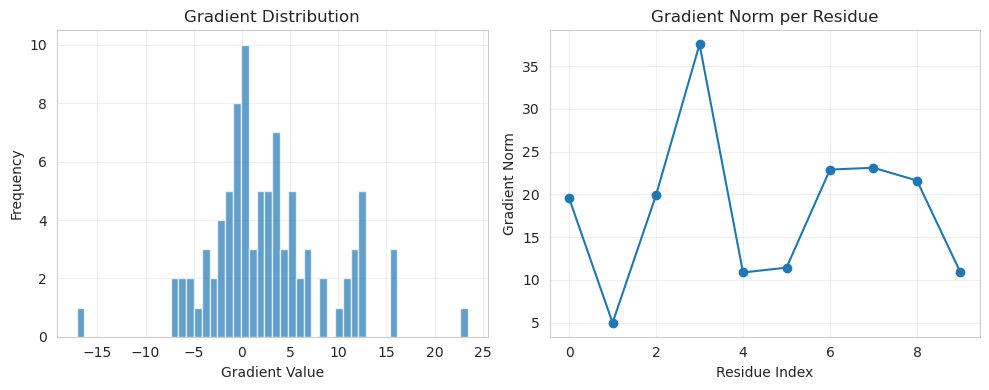

In [ ]:
if xyz_bb.grad is not None:
    grad_norm = xyz_bb.grad.norm().item()
    grad_max = xyz_bb.grad.abs().max().item()
    grad_min = xyz_bb.grad.abs().min().item()
    grad_mean = xyz_bb.grad.abs().mean().item()
    
    print("✅ 梯度能够回传到 xyz_bb!")
    print(f"  梯度形状: {xyz_bb.grad.shape}")
    print(f"  梯度范数: {grad_norm:.6f}")
    print(f"  梯度最大值: {grad_max:.6f}")
    print(f"  梯度最小值: {grad_min:.6f}")
    print(f"  梯度平均值: {grad_mean:.6f}")
    
    # 检查梯度是否全为零
    if grad_norm < 1e-8:
        print(f"\n⚠️  警告: 梯度范数非常小 ({grad_norm:.2e})")
        print("   可能是梯度消失或计算图断开")
    else:
        print(f"\n✅ 梯度正常，可以用于训练")
        
    # 可视化梯度分布
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    grad_flat = xyz_bb.grad.detach().cpu().flatten()
    plt.hist(grad_flat.numpy(), bins=50, alpha=0.7)
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.title('Gradient Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    grad_per_residue = xyz_bb.grad.norm(dim=(2, 3)).squeeze(0).detach().cpu()
    plt.plot(grad_per_residue.numpy(), marker='o')
    plt.xlabel('Residue Index')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm per Residue')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ 梯度无法回传到 xyz_bb")
    print("   xyz_bb.grad = None")
    print("   可能原因:")
    print("   1. 计算图断开")
    print("   2. 某些操作使用了 detach() 或 no_grad()")
    print("   3. adjust_oxygen_pos 的 in-place 操作阻断了梯度")


## 7. 详细检查中间变量的梯度


In [ ]:
# 重新运行前向传播，但这次保存中间变量
xyz_bb_test = torch.randn(B, L, 3, 3, device=device, requires_grad=True)

# 检查从 xyz_bb 到 rotmats 和 trans 的梯度
from BondFlow.data import utils as iu

rotmats = iu.get_R_from_xyz(xyz_bb_test)
trans = xyz_bb_test[:, :, 1, :]

print("中间变量检查:")
print(f"  rotmats.requires_grad = {rotmats.requires_grad}")
print(f"  trans.requires_grad = {trans.requires_grad}")

# 测试简单的反向传播
test_loss = rotmats.sum() + trans.sum()
test_loss.backward()

if xyz_bb_test.grad is not None:
    print(f"✅ get_R_from_xyz 和索引操作保持梯度")
    print(f"   梯度范数: {xyz_bb_test.grad.norm().item():.6f}")
else:
    print("❌ get_R_from_xyz 或索引操作阻断了梯度")


中间变量检查:
  rotmats.requires_grad = True
  trans.requires_grad = True
✅ get_R_from_xyz 和索引操作保持梯度
   梯度范数: 6.221303


## 8. 对比测试：rfdiff backend


In [ ]:
# 测试 rfdiff backend 作为对比
try:
    wrapper_rfdiff = AllAtomWrapper(backend='rfdiff', device=device)
    print("✅ AllAtomWrapper (rfdiff) 创建成功")
    
    xyz_bb_rfdiff = torch.randn(B, L, 3, 3, device=device, requires_grad=True)
    RTs_rfdiff, out14_rfdiff = wrapper_rfdiff(seq, xyz_bb_rfdiff, alphas_sincos)
    
    print(f"  rfdiff 输出形状: {out14_rfdiff.shape}")
    print(f"  rfdiff out14.requires_grad = {out14_rfdiff.requires_grad}")
    
    # 反向传播
    loss_rfdiff = out14_rfdiff.sum()
    loss_rfdiff.backward()
    
    if xyz_bb_rfdiff.grad is not None:
        grad_norm_rfdiff = xyz_bb_rfdiff.grad.norm().item()
        print(f"✅ rfdiff 梯度能够回传，梯度范数: {grad_norm_rfdiff:.6f}")
    else:
        print("❌ rfdiff 梯度无法回传")
        
except Exception as e:
    print(f"⚠️  rfdiff backend 测试失败: {e}")
    print("   跳过对比测试")


✅ AllAtomWrapper (rfdiff) 创建成功
tensor([[[[ 0.7262,  0.0912],
          [-0.3891,  0.5279],
          [ 1.0311, -0.7048]],

         [[-0.3609, -0.0606],
          [ 0.0733,  0.8187],
          [-0.3753,  1.0331]],

         [[-2.4801, -0.4175],
          [-1.1955,  0.8123],
          [-0.3063, -0.3302]],

         [[ 0.9812, -0.6401],
          [-0.4908,  0.2080],
          [-0.9319, -1.5910]],

         [[-1.1753,  0.3581],
          [ 0.4788,  1.3537],
          [-0.1593, -0.4249]],

         [[ 1.3032,  0.4879],
          [ 1.1340, -0.3556],
          [ 0.3094, -0.5003]],

         [[ 0.0176,  0.0782],
          [ 0.1932,  0.4097],
          [-1.5754,  2.2508]],

         [[-0.9143,  1.4840],
          [-0.9109, -0.5291],
          [-1.4790,  0.4323]],

         [[-0.1222, -0.7470],
          [ 1.7093,  0.0579],
          [ 0.8637, -0.5890]],

         [[ 0.5230,  0.9717],
          [-0.2779, -0.6116],
          [ 0.7694,  2.5574]]]])
  rfdiff 输出形状: torch.Size([1, 10, 14, 3])
  rfdi

/WORK/PUBLIC/lulei_work/xjt/Protein_design/BondFlow/rfdiff/util_module.py:334: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  CBrotaxis1 = (CBr-CAr).cross(NCr-CAr)


## 总结

根据以上测试结果：

- ✅ **梯度能够回传**: 如果 `xyz_bb.grad` 不为 None 且梯度范数 > 1e-8
- ❌ **梯度无法回传**: 如果 `xyz_bb.grad` 为 None 或梯度范数 < 1e-8

如果梯度无法回传，可能的原因：
1. `adjust_oxygen_pos` 函数中的 in-place 操作阻断了梯度
2. APM 内部某些操作使用了 `detach()` 或 `no_grad()`
3. 计算图在某个地方断开

建议修复方法：
1. 修改 `adjust_oxygen_pos` 避免 in-place 操作，使用 `clone()` 创建新张量
2. 检查 APM 代码中是否有 `detach()` 调用
